# VAE

In [1]:
from model import VAE

import tensorflow as tf
import keras as K
import numpy as np
import os

### Data Preprocessing

In [2]:
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

### Training the VAE

In [7]:
vae = VAE(image_size=28, channels=1, latent_dim=2)
vae.compile(optimizer=K.optimizers.Adam(learning_rate=1e-5))
callbacks = vae.get_callbacks(log_dir="logs", patience=3)
vae.fit(mnist_digits, epochs=30, batch_size=256, callbacks=callbacks)

Epoch 1/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - kl_loss: 0.0241 - loss: 539.5704 - reconstruction_loss: 539.5463
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - kl_loss: 3.5900 - loss: 520.4803 - reconstruction_loss: 516.8903
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - kl_loss: 30.3720 - loss: 422.4919 - reconstruction_loss: 392.1197
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - kl_loss: 34.7852 - loss: 311.7401 - reconstruction_loss: 276.9549
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - kl_loss: 25.1586 - loss: 269.3354 - reconstruction_loss: 244.1767
Epoch 6/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - kl_loss: 18.9482 - loss: 247.8726 - reconstruction_loss: 228.9246
Epoch 7/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - kl_loss: 15.0213 - loss: 235.3907 - reconstruction_loss: 220.3694
Epoch 8/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - kl_loss: 12.4029 - loss: 227.3227 - reconstruction_loss: 214.9197
Epoch 9/30
274/274 ━━━━━━━━━━━━━━━

In [8]:
for metric in vae.metrics:
    print(f"{metric.name}: {metric.result().numpy()}")

total_loss: 195.83010864257812
reconstruction_loss: 189.9564971923828
kl_loss: 5.87361478805542


Esto da diferente estoy usando un device M3 (a través de Metal Performance Shaders) que en tiene un comportamiento numérico diferente a CUDA. De hecho tuve usar un clip en el kl_loss para evitar explosiones numéricas.

In [9]:
# Save
os.makedirs("./weights", exist_ok=True)
vae.encoder.save("./weights/encoder.keras")
vae.decoder.save("./weights/decoder.keras")

### View Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


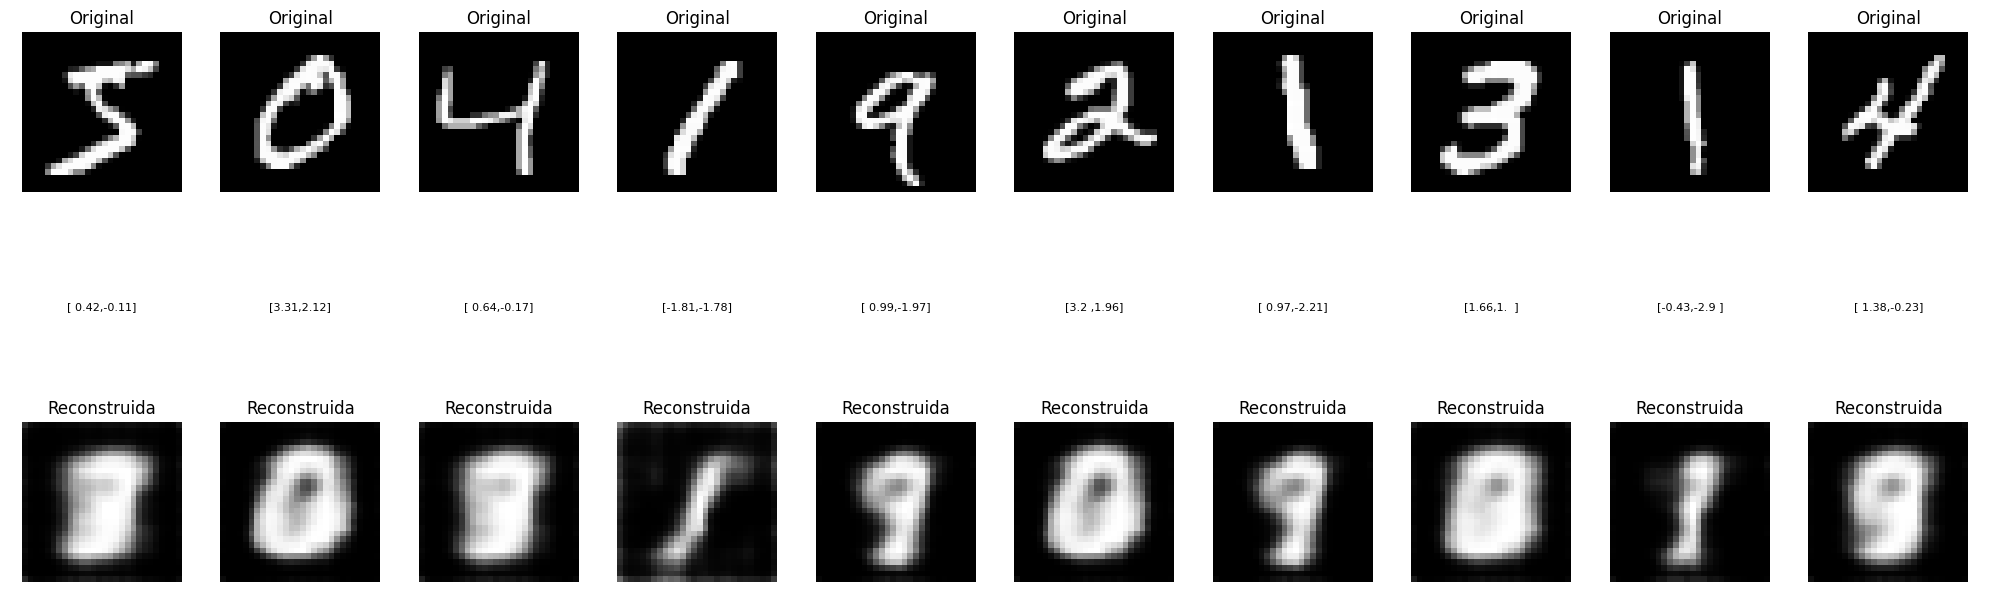

In [11]:
import matplotlib.pyplot as plt

n = 10
example_images = mnist_digits[:n]

# Obtener la representación latente z y las reconstrucciones
z_mean, z_log_var, z = vae.encoder.predict(example_images)
predictions = vae.decoder.predict(z)

plt.figure(figsize=(20, 6))

for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(example_images[i].squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Vector latente z (como texto en una celda)
    ax = plt.subplot(3, n, i + 1 + n)
    ax.axis("off")
    z_text = np.array2string(z[i], precision=2, separator=",")
    ax.text(0.5, 0.5, z_text, ha="center", va="center", fontsize=8)

    # Reconstrucción
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[i].squeeze(), cmap="gray")
    plt.title("Reconstruida")
    plt.axis("off")

plt.tight_layout()
plt.show()
